<a href="https://colab.research.google.com/github/VCosmo/POLOSA/blob/main/SASHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
'''
!ls /content/drive/MyDrive/ColabNotebooks/*.py

!cat '/content/drive/MyDrive/ColabNotebooks/gal4H0.py'

# We'll need to update our path to import from Drive.

import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/')
'''

"\n!ls /content/drive/MyDrive/ColabNotebooks/*.py\n\n!cat '/content/drive/MyDrive/ColabNotebooks/gal4H0.py'\n\n# We'll need to update our path to import from Drive.\n\nimport sys\nsys.path.append('/content/drive/MyDrive/ColabNotebooks/')\n"

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM, z_at_value
from scipy.special import erf
from scipy.interpolate import interp1d
from tqdm import tqdm
import scipy

import seaborn as sns
pal=sns.color_palette('colorblind')

import matplotlib as _mpl

_mpl.rcParams['figure.figsize']= (3.3, 2.5)
_mpl.rcParams['figure.dpi']= 300
_mpl.rcParams['axes.labelsize']= 7
_mpl.rcParams['xtick.labelsize']= 7
_mpl.rcParams['ytick.labelsize']= 7
_mpl.rcParams['legend.fontsize']= 7
_mpl.rcParams['font.size']= 7
_mpl.rcParams['font.family']= 'sans-serif'
_mpl.rcParams['font.sans-serif']= ['DejaVu Sans', 'Arial', 'Helvetica', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']
_mpl.rcParams['mathtext.fontset']='dejavusans'
_mpl.rcParams['axes.linewidth']= 0.5
_mpl.rcParams['grid.linewidth']= 0.5
_mpl.rcParams['lines.linewidth']= 1.
_mpl.rcParams['lines.markersize']= 3.
_mpl.rcParams['savefig.bbox']= 'tight'
_mpl.rcParams['savefig.pad_inches']= 0.01
#mpl.rcParams['text.latex.preamble']= '\usepackage{amsmath, amssymb, sfmath}'

def normal_distribution(x,mu,sigma):
    '''
    Reuturns a simple gaussian likelihood:
    
    Parameters
    ----------
    x: np.array
        Where to evaluate likelihood
    mu,sigma: np.array
        Mean and standard deviation of gaussian
    '''
    var=sigma**2
    return np.power(2*np.pi*var,-0.5)*np.exp(-0.5*np.power((x-mu)/sigma,2.))

def normal_distribution_inco(x,mu,sigma):
    '''
    Reuturns a gaussian likelihood without overall normalization:
    
    Parameters
    ----------
    x: np.array
        Where to evaluate likelihood
    mu,sigma: np.array
        Mean and standard deviation of gaussian
    '''
    var=sigma**2
    return np.exp(-0.5*np.power((x-mu)/sigma,2.))

def GW_detection_probability(dltrue,sigmadl,dlthr):
    '''z
    Return a detection probability given a gaussian likelihood. The detection probability is defined as 
    the integral from -inf to x_thr of a given normal distribution with mean mu and std.
    
    Parameters
    ----------
    dltrue: np.array
        Where to evaluate the det prob
    sigmadl: np.array
        std of the likelihood model
    dlthr: np.array
        Cut for the selection
    '''
    t_thr= (dlthr-dltrue)/sigmadl # Normalized random variable
    return 0.5*(1+erf(t_thr/np.sqrt(2)))

def GW_detection_probability_Heaviside(dltrue,dlthr):
    '''
    A GW detection probability that is a Heaviside step function 
    
    Parameters
    ----------
    dltrue: np.array
        Where to evaluate the det prob
    dlthr: np.array
        Cut for the selection
    '''
    
    out=np.ones_like(dltrue)
    out[dltrue>dlthr]=0.
    return out

def replicate_galaxies(galaxies_list,Ntot=100000,scatter=0.001):
    '''
    This function replicate a list of true redshift of galaxies adding on top some scatter
    
    Parameters
    ----------
    galaxies_list: np.array
        True redshift of galaxies
    Ntot: int
        How many galaxies you want, the code will round the number of clones to generate
    scatter: float
        what is the fractional scatter
    '''
    Nrep=int(np.ceil(Ntot/len(galaxies_list)))
    
    clones=[]
    for i in range(Nrep):
        clones.append((np.random.randn(len(galaxies_list))*scatter+1.)*galaxies_list)
    
    clones=np.hstack(clones)
    return np.hstack([galaxies_list,clones])
    


def build_interpolant(z_obs,sigmazevalobs,zrate,nocom='dvcdz'):
    '''
    This function returns the p(z|c) interpolator assuming constant rate
    
    Parameters
    ----------
    z_obs: array
        List of observed values for galaxies
    z_rate: float
        Maximum redshift for the rate
    '''
    
    zinterpolant=np.exp(np.linspace(np.log(1e-4),np.log(zrate),80000))
    
    interpolant=np.zeros_like(zinterpolant)
    cosmo=FlatLambdaCDM(H0=70.,Om0=0.25)
    sigmaz=0.013*np.power(1+zinterpolant,3.)
    sigmaz[sigmaz>0.015]=0.015
       
    # This is the prior to applied to the interpolant 
    if nocom=='uniform':
        dvcdz_ff=1.
    elif nocom=='dvcdz':
        dvcdz_ff=cosmo.differential_comoving_volume(zinterpolant).value
    else:
        gkde=scipy.stats.gaussian_kde(nocom,bw_method=0.8e-1)
        dvcdz_ff=gkde(interpolant)
        
 
    for i in tqdm(range(len(z_obs))):
        # Initializes array for the calculation of the interpolant
        zmin=np.max([0.,z_obs[i]-5*sigmazevalobs[i]])
        zeval=np.linspace(zmin,z_obs[i]+5*sigmazevalobs[i],5000)
        sigmazeval=0.013*np.power(1+zeval,3.)
        sigmazeval[sigmazeval>0.015]=0.015
        
        if nocom=='uniform':
            dvcdz=1.
        elif nocom=='dvcdz':
            dvcdz=cosmo.differential_comoving_volume(zeval).value
        else:
            dvcdz=gkde(zeval)
        
        # The line below is the redshift likelihood times the prior.
        pval=normal_distribution(zeval,mu=z_obs[i],sigma=sigmazeval)*dvcdz
        normfact=scipy.integrate.simpson(pval,zeval) # Renormalize        
        evals=normal_distribution(zinterpolant,mu=z_obs[i],sigma=sigmaz)*dvcdz_ff/normfact
        
        if np.all(np.isnan(evals)):
            continue
        interpolant+=evals # Sum to create the interpolant
    interpolant/=scipy.integrate.simpson(interpolant,zinterpolant)
    return interp1d(zinterpolant,np.log(interpolant),bounds_error=False,fill_value=-np.inf),zinterpolant

def draw_gw_events(Ndet,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate):
    '''
    This function draws the GW events and applies a selection based on the observed luminosity distance
    
    Parameters
    ----------
    Ndet: Number of GW detections you want
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    galaxies_list: array with the redshift of the galaxies
    true_cosmology: Astropy FlatLambdaCDM class for the true cosmology
    zcut_rate: until what redshift GW events to happen
    
    Returns
    -------
    Observed luminosity distance in Mpc, True luminosity distance in Mpc, True GW redshift, Standard deviation used to draw sample
    '''
    
    # M = abs.magn.; m = apparent magn.; d= distance in Mpc
    Ngw=100000 # Just a random number high enough to have detections
    
    rate_term = np.zeros_like(galaxies_list) # Initialize the rate term
    rate_term[galaxies_list<=zcut_rate]=1.
     # Draw randomly from the galaxy list, takes into account also a rate cut
    gw_redshift=np.random.choice(galaxies_list,size=Ngw,p=(rate_term/rate_term.sum())*np.power(L, alfa)) #p is the prob. associated to every element of the array
    gw_true_dl=true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
    std_dl=gw_true_dl*sigma_dl # Defines the sigma for the gaussian
    gw_obs_dl=np.random.randn(len(gw_true_dl))*std_dl+gw_true_dl # Generate an observed value, a.k.a. data
    gw_detected =  np.where(gw_obs_dl<dl_thr)[0] # Finds the detected GW events
    gw_detected = gw_detected[:Ndet:] # Takes the first Ndet GW events detected
    print('You detected {:d} binaries out of {:d} simulated'.format(len(gw_detected),Ngw))
    
    return gw_obs_dl[gw_detected], gw_true_dl[gw_detected], gw_redshift[gw_detected],std_dl[gw_detected]

def M2m(M,dl):
    '''
    Converts Absolute bolometric magnitude to apparent magnitude
   
    Parameters
    ----------
    M: np.array
        Absolute bolometric magnitude
    dl: np.array
        Luminosity distance in Mpc
   
    Returns
    -------
    m: np.array
        Apparent magnitude
    '''
  # Note that the distance is Mpc here. See Eq. 2 of https://arxiv.org/abs/astro-ph/0210394
    dist_modulus=5*np.log10(dl)+25.
    return M+dist_modulus


def m2M(m,dl):
    '''
    Converts apparent magnitude to Absolute bolometric magnitude
   
    Parameters
    ----------
    m: np.array
        apparebt magnitude
    dl: np.array
        Luminosity distance in Mpc

   
    Returns
    -------
    M: np.array
        Absolute bolometric magnitude
    '''
    # Note that the distance is Mpc here. See Eq. 2 of https://arxiv.org/abs/astro-ph/0210394
    dist_modulus=5*np.log10(dl)+25.
    return m-dist_modulus



def L2M(L):
    '''
    Converts Luminosity in Watt to Absolute bolometric magnitude
   
    Parameters
    ----------
    L: np.array
        Luminosity in Watt
   
    Returns
    -------
    M: np.array
        Absolute bolometric magnitude
    '''
    # From Resolution B2 proposed by IAU, see e.g. Pag. 2, Eq. 2 of https://www.iau.org/static/resolutions/IAU2015_English.pdf
    return -2.5*np.log10(L)+71.197425

def M2L(M):
    '''
    Converts Absolute bolometric magnitude to Luminosity in Watt
   
    Parameters
    ----------
    M: np.array
        Absolute bolometric magnitude
   
    Returns
    -------
    L: np.array
        Luminosity in Watt
    '''
    # From Pag. 2, Eq. 1-2 of https://www.iau.org/static/resolutions/IAU2015_English.pdf
    return 3.0128e28*np.power(10.,-0.4*M)

def draw_gw_events_L(Ndet,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate, L, alpha):
    '''
    This function draws the GW events and applies a selection based on the observed luminosity distance
    
    Parameters
    ----------
    Ndet: Number of GW detections you want
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    galaxies_list: array with the redshift of the galaxies
    true_cosmology: Astropy FlatLambdaCDM class for the true cosmology
    zcut_rate: until what redshift GW events to happen
    
    Returns
    -------
    Observed luminosity distance in Mpc, True luminosity distance in Mpc, True GW redshift, Standard deviation used to draw sample
    '''
    
    # M = abs.magn.; m = apparent magn.; d= distance in Mpc
    Ngw=100000 # Just a random number high enough to have detections
    
    rate_term = np.zeros_like(galaxies_list) # Initialize the rate term
    rate_term[galaxies_list<=zcut_rate]=1.
    rate_term*=np.power(L, alpha)
     # Draw randomly from the galaxy list, takes into account also a rate cut
    gw_redshift=np.random.choice(galaxies_list,size=Ngw,p=rate_term/rate_term.sum()) #p is the prob. associated to every element of the array
    gw_true_dl=true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
    std_dl=gw_true_dl*sigma_dl # Defines the sigma for the gaussian
    gw_obs_dl=np.random.randn(len(gw_true_dl))*std_dl+gw_true_dl # Generate an observed value, a.k.a. data
    gw_detected =  np.where(gw_obs_dl<dl_thr)[0] # Finds the detected GW events
    gw_detected = gw_detected[:Ndet:] # Takes the first Ndet GW events detected
    print('You detected {:d} binaries out of {:d} simulated'.format(len(gw_detected),Ngw))
    
    return gw_obs_dl[gw_detected], gw_true_dl[gw_detected], gw_redshift[gw_detected],std_dl[gw_detected]

def draw_gw_events_inco(Ndet,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate):
    '''
    This function draws the GW events and applies a double counting on p(z).
    
    Parameters
    ----------
    Ndet: Number of GW detections you want
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    galaxies_list: array with the redshift of the galaxies
    true_cosmology: Astropy FlatLambdaCDM class for the true cosmology
    zcut_rate: until what redshift GW events to happen
    
    Returns
    -------
    Observed luminosity distance in Mpc, True luminosity distance in Mpc, True GW redshift, Standard deviation used to draw sample
    '''
    
    Ngw=100000 # Just a random number high enough to have detections
    rate_term = np.zeros_like(galaxies_list) # Initialize the rate term
    rate_term[galaxies_list<=zcut_rate]=1.
    gw_redshift=np.random.choice(galaxies_list,size=Ngw,p=rate_term/rate_term.sum()) # Draw from galaxies according to rate
    gw_true_dl=true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
    std_dl=gw_true_dl*sigma_dl
    gw_obs_dl=gw_true_dl
    gw_detected =  np.where(gw_obs_dl<dl_thr)[0]
    gw_detected = gw_detected[:Ndet:]
    print('You detected {:d} binaries out of {:d} simulated'.format(len(gw_detected),Ngw))
    
    return gw_obs_dl[gw_detected], gw_true_dl[gw_detected], gw_redshift[gw_detected],std_dl[gw_detected]


def galaxy_catalog_analysis_accurate_redshift(H0_array,galaxies_list,zcut_rate,gw_obs_dl,sigma_dl,dl_thr):
    '''
    This function will perform the H0 analysis in the limit that the redshift estimate from the catalog
    is without uncertainties
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    galaxies_list: array with the redshift of the galaxies
    zcut_rate: until what redshift GW events to happen
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''
    
    
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    rate_term = np.zeros_like(galaxies_list)
    rate_term[galaxies_list<=zcut_rate]=1.
    p_z_given_C=rate_term/rate_term.sum() # Calculates what galaxies have a non-zero rate
    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    dltimesH0=cosmotrial.luminosity_distance(galaxies_list).to('Mpc').value*cosmotrial.H0.value # Initialize dltimes H0

    for j,H0 in tqdm(enumerate(H0_array),desc='running on H0'):
        dltrial=dltimesH0/H0 # Calculations of dl
        
        # Selection bias
        selection_bias=np.sum(GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*p_z_given_C)
        for i,idx in enumerate(gw_obs_dl):
            # Integral at the numerator (it is a sum since we measure perfectly redshift)
            numerator = np.sum(normal_distribution(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*p_z_given_C)
            posterior_matrix[i,j]=numerator/selection_bias

    # Normalize and combine posteriors
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)
        
    return posterior_matrix,combined

def galaxy_catalog_analysis_accurate_redshift_L(H0_array,galaxies_list,zcut_rate,gw_obs_dl,sigma_dl,dl_thr, m, alpha):
    '''
    This function will perform the H0 analysis in the limit that the redshift estimate from the catalog
    is without uncertainties
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    galaxies_list: array with the redshift of the galaxies
    zcut_rate: until what redshift GW events to happen
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Fractional value of the std for the GW likelihood
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''
    
    
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    rate_term = np.zeros_like(galaxies_list)
    rate_term[galaxies_list<=zcut_rate]=1.
    p_z_given_C=rate_term/rate_term.sum() # Calculates what galaxies have a non-zero rate
    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    dltimesH0=cosmotrial.luminosity_distance(galaxies_list).to('Mpc').value*cosmotrial.H0.value # Initialize dltimes H0

    for j,H0 in tqdm(enumerate(H0_array),desc='running on H0'):
        dltrial=dltimesH0/H0 # Calculations of dl
        Labs=M2L(m2M(m, dltrial))/1e47
        # Selection bias
        selection_bias=np.sum(GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*p_z_given_C*np.power(Labs, alpha))
        for i,idx in enumerate(gw_obs_dl):
            # Integral at the numerator (it is a sum since we measure perfectly redshift)
            numerator = np.sum(normal_distribution(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*p_z_given_C*np.power(Labs, alpha))
            posterior_matrix[i,j]=numerator/selection_bias

    # Normalize and combine posteriors
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)
        
    return posterior_matrix,combined

def galaxy_catalog_analysis_photo_redshift_inco(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr):
    '''
    This function will perform the H0 analysis assuming errors on galaxy redshift but INCORRETLY using and Heaviside step function as GW detection probability.
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    zinterpo: Interpolant for p(z|C)
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Array of sigma for dl (in Mpc) used to draw gw_obs_dl
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''

    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    # Evaluated d_L times H0
    dltimesH0=cosmotrial.luminosity_distance(zinterpo.x).to('Mpc').value*cosmotrial.H0.value
    selection_bias=np.zeros_like(H0_array)
    pzeval=np.exp(zinterpo(zinterpo.x))
    
    
    # Calculate the selection effect on the grid just once
    for j,H0 in tqdm(enumerate(H0_array)):
        dltrial=dltimesH0/H0
        integrand=GW_detection_probability_Heaviside(dltrial,dlthr=dl_thr)*pzeval
        selection_bias[j]=scipy.integrate.simpson(integrand,zinterpo.x)
    
    # Loop on the GW events and H0 to compute posteriors
    for i,idx in tqdm(enumerate(gw_obs_dl),desc='Running on GW events'):
        for j,H0 in enumerate(H0_array):
            dltrial=dltimesH0/H0
            integrand=normal_distribution(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*pzeval
            # Do the integral of the numerator in redshift
            numerator = scipy.integrate.simpson(integrand,zinterpo.x)
            posterior_matrix[i,j]=numerator/selection_bias[j]
            
    # Combine the result
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)

    return posterior_matrix,combined


# def galaxy_catalog_analysis_photo_redshift(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr):
#     '''
#     This function will perform the H0 analysis assuming errors on the redshift determination.
    
#     Parameters
#     ---------
#     H0_array: grid of H0 for the analysis
#     zinterpo: Interpolant for p(z|C)
#     gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
#     sigma_dl: Array of sigma for dl (in Mpc) used to draw gw_obs_dl
#     dl_thr: Threshold for detection in Mpc
    
#     Returns
#     -------
#     Posterior matrix (raws events, columns H0) and combined posterior
#     '''

#     cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
#     posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
#     # Evaluated d_L times H0
#     dltimesH0=cosmotrial.luminosity_distance(zinterpo.x).to('Mpc').value*cosmotrial.H0.value
    
#     funcinv=interp1d(dltimesH0,zinterpo.x,fill_value=np.inf,bounds_error=False)
       
#     selection_bias=np.zeros_like(H0_array)
#     pzeval=zinterpo(zinterpo.x)
    
    
#     # Calculate the selection effect on the grid just once
#     for j,H0 in tqdm(enumerate(H0_array)):
#         dltrial=dltimesH0/H0
#         integrand=GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*pzeval
#         selection_bias[j]=scipy.integrate.simpson(integrand,zinterpo.x)
    
#     # Loop on the GW events and H0 to compute posteriors
#     for i,idx in tqdm(enumerate(gw_obs_dl),desc='Running on GW events'):
#         dltrial=np.linspace(np.max([0,gw_obs_dl[i]*(1-5*sigma_dl)]),gw_obs_dl[i]*(1+10*sigma_dl),50000)
#         for j,H0 in enumerate(H0_array):
#             zvals=funcinv(dltrial*H0)
#             idx=np.where(zvals!=np.inf)[0]
#             integrand=normal_distribution(gw_obs_dl[i],mu=dltrial[idx],sigma=sigma_dl*dltrial[idx])*zinterpo(zvals[idx])
#             # Do the integral of the numerator in redshift
#             numerator = scipy.integrate.simpson(integrand,zvals[idx])
#             posterior_matrix[i,j]=numerator/selection_bias[j]
            
#     # Combine the result
#     combined=np.ones_like(H0_array)
#     for i,idx in enumerate(gw_obs_dl):
#         posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
#         combined*=posterior_matrix[i,:]
#         combined/=scipy.integrate.simpson(combined,H0_array)

#     return posterior_matrix,combined


def galaxy_catalog_analysis_photo_redshift(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr):
    '''
    This function will perform the H0 analysis assuming errors on the redshift determination.
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    zinterpo: Interpolant for p(z|C)
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Array of sigma for dl (in Mpc) used to draw gw_obs_dl
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''

    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    # Evaluated d_L times H0
    dltimesH0=cosmotrial.luminosity_distance(zinterpo.x).to('Mpc').value*cosmotrial.H0.value
    selection_bias=np.zeros_like(H0_array)
    pzeval=np.exp(zinterpo(zinterpo.x))
    
    
    # Calculate the selection effect on the grid just once
    for j,H0 in tqdm(enumerate(H0_array)):
        dltrial=dltimesH0/H0
        integrand=GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*pzeval
        selection_bias[j]=scipy.integrate.simpson(integrand,zinterpo.x)
    
    # Loop on the GW events and H0 to compute posteriors
    for i,idx in tqdm(enumerate(gw_obs_dl),desc='Running on GW events'):
        for j,H0 in enumerate(H0_array):
            dltrial=dltimesH0/H0
            integrand=normal_distribution(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*pzeval
            # Do the integral of the numerator in redshift
            numerator = scipy.integrate.simpson(integrand,zinterpo.x)
            posterior_matrix[i,j]=numerator/selection_bias[j]
            
    # Combine the result
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)

    return posterior_matrix,combined
                
                

        
def galaxy_catalog_analysis_photo_redshift_GWlikelihood_inconsistency(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr):
    '''
    This function will perform the H0 analysis assuming errors on the redshift determination and no normalization in the luminosity distance
    
    Parameters
    ---------
    H0_array: grid of H0 for the analysis
    zinterpo: Interpolant for p(z|C)
    gw_obs_dl: Array containing observed values for the GW luminosity distance in Mpc
    sigma_dl: Array of sigma for dl (in Mpc) used to draw gw_obs_dl
    dl_thr: Threshold for detection in Mpc
    
    Returns
    -------
    Posterior matrix (raws events, columns H0) and combined posterior
    '''

    cosmotrial=FlatLambdaCDM(H0=70.,Om0=0.25)
    posterior_matrix = np.ones([len(gw_obs_dl),len(H0_array)])
    # Evaluated d_L times H0
    dltimesH0=cosmotrial.luminosity_distance(zinterpo.x).to('Mpc').value*cosmotrial.H0.value
    selection_bias=np.zeros_like(H0_array)
    pzeval=np.exp(zinterpo(zinterpo.x))
    
    
    # Calculate the selection effect on the grid just once
    for j,H0 in tqdm(enumerate(H0_array)):
        dltrial=dltimesH0/H0
        integrand=GW_detection_probability_Heaviside(dltrial,dlthr=dl_thr)*pzeval
        #integrand=GW_detection_probability(dltrial,sigmadl=sigma_dl*dltrial,dlthr=dl_thr)*pzeval
        selection_bias[j]=scipy.integrate.simpson(integrand,zinterpo.x)
    
    # Loop on the GW events and H0 to compute posteriors
    for i,idx in tqdm(enumerate(gw_obs_dl),desc='Running on GW events'):
        for j,H0 in enumerate(H0_array):
            dltrial=dltimesH0/H0
            integrand=normal_distribution_inco(gw_obs_dl[i],mu=dltrial,sigma=sigma_dl*dltrial)*pzeval
            # Do the integral of the numerator in redshift
            numerator = scipy.integrate.simpson(integrand,zinterpo.x)
            posterior_matrix[i,j]=numerator/selection_bias[j]
            
    # Combine the result
    combined=np.ones_like(H0_array)
    for i,idx in enumerate(gw_obs_dl):
        posterior_matrix[i,:]/=scipy.integrate.simpson(posterior_matrix[i,:],H0_array)
        combined*=posterior_matrix[i,:]
        combined/=scipy.integrate.simpson(combined,H0_array)

    return posterior_matrix,combined

In [24]:
#from gal4H0 import *
from scipy.stats import gaussian_kde
true_cosmology = FlatLambdaCDM(H0=70.,Om0=0.25) # True cosmology

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
# Define the path to the catalog compressed CSV file:
catalog_filename = "/content/drive/MyDrive/13826.csv.bz2"  
# Define the list of columns that uniquely identify each row
data = pd.read_csv(catalog_filename, sep=",", comment='#', na_values=r'\N', compression='bz2')

abs_M=data['abs_mag_r'].to_numpy()[0:1000:]
galaxies_list=data['z'].to_numpy()[0:1000:]
Labs=M2L(abs_M)
app_m=M2m(abs_M, true_cosmology.luminosity_distance(galaxies_list).to('Mpc').value)
print(len(app_m))

10


0.1
You detected 10 binaries out of 100000 simulated


running on H0: 4000it [00:01, 3148.79it/s]
running on H0: 4000it [00:01, 3563.63it/s]
running on H0: 4000it [00:01, 3606.82it/s]


0.2
You detected 10 binaries out of 100000 simulated


running on H0: 4000it [00:02, 1760.06it/s]
running on H0: 4000it [00:02, 1876.33it/s]
running on H0: 4000it [00:01, 2480.76it/s]


0.3
You detected 10 binaries out of 100000 simulated


running on H0: 4000it [00:01, 3505.50it/s]
running on H0: 4000it [00:02, 1810.00it/s]
running on H0: 4000it [00:02, 1689.84it/s]


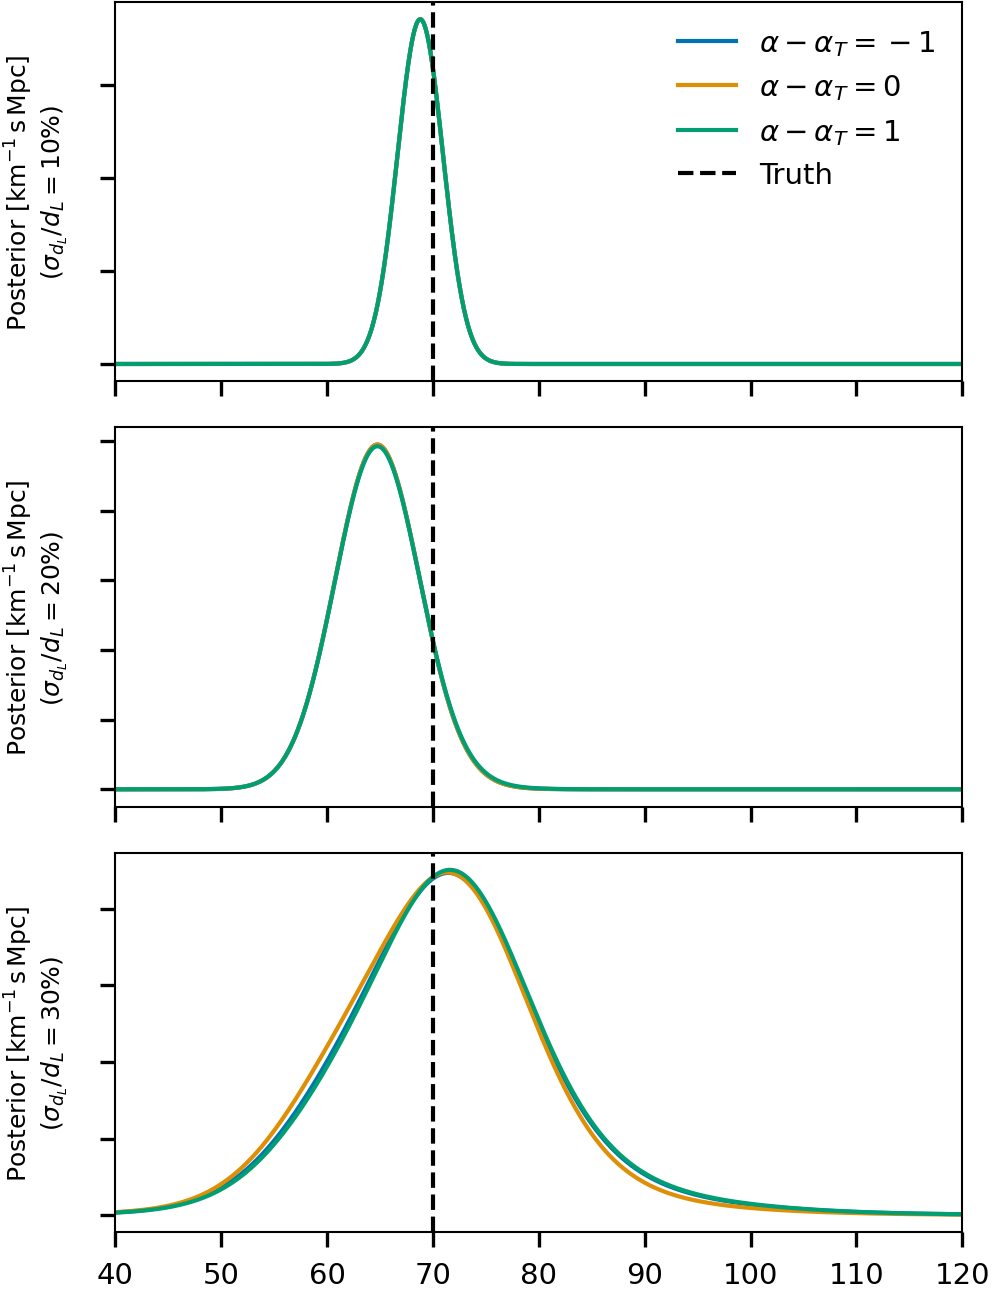

In [29]:
np.random.seed(1) #Random seed

alpha=0
alphas= [alpha-1, alpha, alpha+1]
sigmas=[0.1,0.2,0.3]
Ngw=100
zcut_rate=1.4
dl_thr=1550
H0_array=np.linspace(40,120,4000)

posteriors={'H0_grid':H0_array}

###########################################################

fig, ax= plt.subplots(3,1,figsize=(3.5,4.5),sharex=True)
colors=[pal[0],pal[1],pal[2]]
lines=['solid','--',':']

labels_1=[r'$\alpha-\alpha_{T}=-1$',
        r'$\alpha-\alpha_{T}=0$',
        r'$\alpha-\alpha_{T}=1$',]

labels_2=[r'$\sigma_{d_L}/d_L=10\%$',
         r'$\sigma_{d_L}/d_L=20\%$',
         r'$\sigma_{d_L}/d_L=30\%$']


#########################################################

for j in range(3):
    print(sigmas[j])
    sigma_dl=sigmas[j]
    gw_obs_dl,_,_,std_dl=draw_gw_events_L(Ngw,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate, Labs, alpha) #observed dL; std used to draw sample    
    
    for i in range(3):
        posterior_matrix,combined=galaxy_catalog_analysis_accurate_redshift_L(H0_array,galaxies_list,zcut_rate,gw_obs_dl,sigma_dl,dl_thr, app_m, alphas[i]) 
        
        posteriors['L_'+str(sigmas[j])+'_'+'signle']=posterior_matrix
        posteriors['L_'+str(sigmas[j])+'_'+'combined']=combined
        
        ax[j].plot(H0_array,posteriors['L_'+str(sigmas[j])+'_'+'combined'],ls='solid',color=colors[i],label=labels_1[i])


  

for j in range(3):
    ax[j].axvline(70.,ls='--',color='k',label='Truth')
    ax[j].set_xlim([40,120])    
    ax[j].yaxis.set_ticklabels([])
    ax[j].set_ylabel(r'Posterior ${\rm[km^{-1} \,s \,Mpc]}$'+'\n'+'('+labels_2[j]+')',fontsize=6)

ax[0].legend(frameon=False,ncol=1)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ColabNotebooks/IF_100_1000_cat6.png')
